<a href="https://colab.research.google.com/github/jtwang1027/business_analysis/blob/master/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient boosted trees on a year's worth of sales data to predict Gross Sales

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb


#Ingesting Data and processing

In [0]:

data1=pd.read_csv('/content/drive/My Drive/feb_2020-dataset.csv')



The data has been preprocessed with day of week one hot encoded as well month, date, and year separated into their own columns. The Gross Sales reflect the cumulative sales generated in that hour.

In [5]:
data1.sample(4)

,Hour,Gross Sales,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Month,date,Year
2127,17,91.10,0,1,0,0,0,0,0,7,1,2019
368,16,194.62,0,0,1,0,0,0,0,2,2,2019
508,22,102.21,0,0,0,0,1,0,0,2,14,2019
1380,13,102.77,0,0,0,1,0,0,0,4,28,2019


It is worth noting the **time-dependent** nature of this data. So a random split of the whole dataset is *cheating*. It'd be better to split the data into *past* and *future*, and train it on the past and evaluate it on the future.

In [0]:
data1.sort_values(['Year', 'Month','date','Hour'], ascending=[True]*4, inplace=True)#sort based on date and predict last 25% values

In [0]:
#check that the df is sorted
data1.head(5)

,Hour,Gross Sales,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Month,date,Year
0,11,8.78,0,0,0,0,1,0,0,1,3,2019
1,12,96.74,0,0,0,0,1,0,0,1,3,2019
2,13,48.41,0,0,0,0,1,0,0,1,3,2019
3,14,79.26,0,0,0,0,1,0,0,1,3,2019
4,15,73.65,0,0,0,0,1,0,0,1,3,2019


In [0]:
y=data1['Gross Sales'] 
X= data1.drop(['Gross Sales'],axis=1)
X=X.reindex(sorted(X.columns),axis=1) #put in alphabetical order

In [0]:
xtrain= X.iloc[:3589,:]#split 80-20
ytrain= y.iloc[:3589]#split 80-20

xtest= X.iloc[3589:,:]#split 80-20
ytest= y.iloc[3589:]#split 80-20

#Model fitting and evaluation


In [13]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_model.fit(xtrain, ytrain)

y_pred = xgb_model.predict(xtest)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [14]:
mse=sqrt(mean_squared_error(ytest, y_pred))
f'RMSE: ${round(mse,2)}'

'RMSE: $35.97'

In [15]:
#mean average error
mae=abs(ytest-y_pred).sum()/ len(y_pred)
f'mean average error: ${round(mae,2)}'

'mean average error: $28.49'

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Freq')

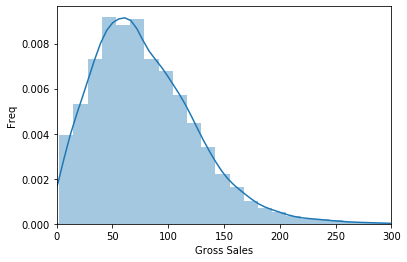

In [45]:
sns.distplot(data1['Gross Sales'])
plt.xlim(0,300)
plt.xlabel('Gross Sales')
plt.ylabel('Freq')

#Conclusion
Although this xgboost model is outperforming linear regression, the MAE is still relatively significant. Perhaps we can do better using other models. Or, adding factors (such as events, weather) to improve this model.

#Followup questions:



1.   Would more data help?
2.  What are the most important features of this model currently?



1. Would more data help? 
We can assess this by testing this xgboost model through time. We have ~13.5 months of data, and will divide it into 30 time periods (iteratively generating models until the present period and evaluating them on *future* data.)

In [0]:
all_mse=[]
nrows=X.shape[0]
for k in range(1,31):
  #set train and test data
  nrows_train= int(nrows*k/31) #fraction of data to use

  xtrain= X.iloc[:nrows_train,:]
  ytrain= y.iloc[:nrows_train]

  xtest= X.iloc[nrows_train:,:]
  ytest= y.iloc[nrows_train:]
  xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

  xgb_model.fit(xtrain, ytrain)

  y_pred = xgb_model.predict(xtest)
  rmse=sqrt(mean_squared_error(ytest, y_pred))

  all_mse.append(rmse)

Text(0.5, 0, 'Time (arbitray proportion)')

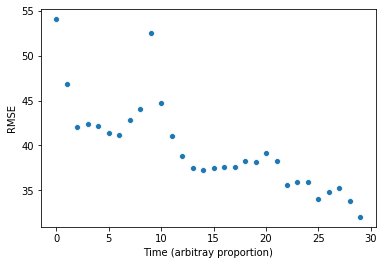

In [52]:
sns.scatterplot(list(range(len(all_mse))),all_mse)
plt.ylabel('RMSE')
plt.xlabel('Time (arbitray proportion)')

This suggests that more data is helping to improve the model. However, this trend could also be influenced by over-fitting. Measurements toward the right are evaluated on less and less data.